# Cleaning and EDA

In this project we are looking at the titles and comments from r/SteamDeck and r/linux_gaming. In this notebook we will be exploring the datasets and seeing what information can be gleamed, along with some potential minor cleaning along the way. 

### Imports and configuration

In [69]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re

# Color theme stuff
import mplcatppuccin
from mplcatppuccin.colormaps import get_colormap_from_list
from mplcatppuccin.palette import load_color

from sklearn.feature_extraction.text import CountVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
# Allowing more text from the Title and Comments to be shown.
pd.options.display.max_colwidth = 600

In [3]:
# This line is for our plot color schemes down the line.
mpl.style.use("mocha")

In [4]:
# Grabbing the Title data and storing it in a dataframe
titles = pd.read_csv('../data/linux_gaming_SteamDeck_merged_title_data.csv')

# Grabbing the Comment data and storing it in a dataframe
comments = pd.read_csv('../data/linux_gaming_SteamDeck_merged_comment_data.csv')

In [5]:
titles.head()

,title_id,title,subreddit
0,12ysmfy,Improved Wine gaming with exeCute,linux_gaming
1,12yb3qz,There is a lot of native Linux games. What would you recomend?,linux_gaming
2,12yfibp,What is your favorite open source Linux game? Mine is Wideland (Best way to describe is the way Settlers 3 should have been),linux_gaming
3,12yagh3,Wiki is getting attacked by spam bots!,linux_gaming
4,12yg5qp,PSA: the 8bitdo ultimate (bluetooth + 2.4gz) controller doesn't work out of the box on most linux distributions,linux_gaming


In [6]:
comments.head()

,comment_id,comments,subreddit
0,jhjsr22,I’m sorry you lost all your friends from gaming too much,SteamDeck
1,jhjz43t,"This feels like an all too poignant commentary on my life. A bunch of games, no friends and no money.",SteamDeck
2,jhjtkl6,"I also have 0,00 Money!",SteamDeck
3,jhjrdnr,I was worried your friend count had gone up. It was only that your games quadrupled. Whew!,SteamDeck
4,jhk1d07,Haha. I honestly thought the 100 referred to cash in the wallet and the joke being about losing 100 friends. Just realised it was about the 100 games. 🤦🏼‍♀️,SteamDeck


Let's look at how much data we have. 

In [7]:
print(titles.shape)

print(comments.shape)

(3869, 3)
(64347, 3)


In [8]:
print(titles['subreddit'].value_counts())
print('-'*30)
print(comments['subreddit'].value_counts())

SteamDeck       2622
linux_gaming    1247
Name: subreddit, dtype: int64
------------------------------
SteamDeck       46285
linux_gaming    18062
Name: subreddit, dtype: int64


In [9]:
titles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3869 entries, 0 to 3868
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title_id   3869 non-null   object
 1   title      3869 non-null   object
 2   subreddit  3869 non-null   object
dtypes: object(3)
memory usage: 90.8+ KB


In [10]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64347 entries, 0 to 64346
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comment_id  64347 non-null  object
 1   comments    64346 non-null  object
 2   subreddit   64347 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB


### Imbalanced Data
As we can see above, we have a pretty imbalanced set of data, with the majority of our data being from r/SteamDeck, by it representing close to 2/3 of our dataset. This is because the data has been pulled regularly from the Reddit API which limits the amount of posts that can be collected to the the first 1000 posts in the respective category. Gathering data over time by repeatedly hitting the api and dropping duplicates will lead to the more popular and active subreddit getting more data than the other.

Because of this imbalance of data, we will have to be more aware of our various results in through out this study. 

---

## Looking at lengths
We have a good amount of titles and comments. Let's add length and word count column to get an idea of the individual sizes of the titles and comments. We can then later examine them to help us find patterns between our 2 different subreddits, and to help us spot things that should be cleaned or taken note of for later work. 

In [11]:
# Forcing all the values in these columns to be read as Strings.
# There are instances where a title or comment may just contain numbers,
# so we much make sure ALL values are read as a string
titles['title'] = titles['title'].astype(str)
comments['comments'] = comments['comments'].astype(str)

In [12]:
# Adding a column for length and word count to both the title set and the comment set.
titles['title_length'] = [len(title) for title in titles['title']]
titles['title_word_count'] = [len(title.split()) for title in titles['title']]

comments['comment_length'] = [len(comment) for comment in comments['comments']]
comments['comment_word_count'] = [len(comment.split()) for comment in comments['comments']]

In [13]:
titles.head()

,title_id,title,subreddit,title_length,title_word_count
0,12ysmfy,Improved Wine gaming with exeCute,linux_gaming,33,5
1,12yb3qz,There is a lot of native Linux games. What would you recomend?,linux_gaming,62,12
2,12yfibp,What is your favorite open source Linux game? Mine is Wideland (Best way to describe is the way Settlers 3 should have been),linux_gaming,124,23
3,12yagh3,Wiki is getting attacked by spam bots!,linux_gaming,38,7
4,12yg5qp,PSA: the 8bitdo ultimate (bluetooth + 2.4gz) controller doesn't work out of the box on most linux distributions,linux_gaming,111,18


In [14]:
comments.head()

,comment_id,comments,subreddit,comment_length,comment_word_count
0,jhjsr22,I’m sorry you lost all your friends from gaming too much,SteamDeck,56,11
1,jhjz43t,"This feels like an all too poignant commentary on my life. A bunch of games, no friends and no money.",SteamDeck,102,20
2,jhjtkl6,"I also have 0,00 Money!",SteamDeck,23,5
3,jhjrdnr,I was worried your friend count had gone up. It was only that your games quadrupled. Whew!,SteamDeck,90,17
4,jhk1d07,Haha. I honestly thought the 100 referred to cash in the wallet and the joke being about losing 100 friends. Just realised it was about the 100 games. 🤦🏼‍♀️,SteamDeck,156,29


Let's see what the **shortest** and **longest** titles and comments look like.

In [15]:
titles.sort_values(by='title_word_count', ascending=True).head(20)

,title_id,title,subreddit,title_length,title_word_count
2210,12tndko,Help!,SteamDeck,5,1
366,12my173,Skyrim,linux_gaming,6,1
25,12y9sod,VrChat,linux_gaming,6,1
3439,12rd5zx,Ventilation,SteamDeck,11,1
3670,12qebiz,Question,SteamDeck,8,1
2677,12zyky1,Help?,SteamDeck,5,1
3609,12qn4q9,gta5,SteamDeck,4,1
1693,12w6h1m,Help!!!,SteamDeck,7,1
1007,121xipr,VK_ERROR_DEVICE_LOST,linux_gaming,20,1
3268,12sgpts,Help,SteamDeck,4,1


In [16]:
titles.sort_values(by='title_word_count', ascending=False).head(20)

,title_id,title,subreddit,title_length,title_word_count
2567,12zxrci,Has anyone tried one of these stations with their Deck? I've been using a third party dock for a while (with my Deck mostly in desktop mode as a PC) and I got the Dbrand case which made it too bulky for the dock. I was thinking about one of these stations so I could leave the grip on at all times.,SteamDeck,298,62
1930,12uzwuo,Does An SSD make that much of a difference in games running on deck ?. im gonna be daily driving it for a couple weeks while my PC is in the shop. I assume maybe load times are like 10-15% better but for like 50% of the price extra idk doesnt seem worth it for deck with how low performance it is,SteamDeck,296,62
3470,12rrksu,"Does anyone know how to access the yellow bar and find out what it is? Seems like every time I download a game it gets bigger. If it keeps up I’m gonna run out of space, every game I’ve downloaded is on my SD card. Thought it was the protons but they are listed as games or the blue bar…",SteamDeck,287,60
3804,12vmsuh,Darn good first attempt at applying a skin cover. I found its best when working the last bits to be gentle with pushing the rest down; don't try to FORCE the bend to go where you want or it'll crease. Just heat and work little bits at a time. Kinda bummed there isn't a red and blue back as well.,SteamDeck,296,60
3477,12re9sc,"I wanted to use it to play Guilty Gear strive modded, I did do it manually once but Unverum helps organize it, there was another post of someone who had trouble running unverum but I need more fleshed out steps on what to do, for example when I try opening the application it asks me this",SteamDeck,288,56
2273,130pzdv,"Skill Up on Twitter: I’ll have a Jedi Survivor review up later but right now I can say that it’s a great game that you should absolutely avoid if you’re playing on PC (for now, at least). The port is a total mess, namely awful FPS performance that cannot be improved through any settings changes",SteamDeck,295,55
2410,131hag1,"SteamDeck EmuDeck update SNAFU: I added way too many roms with the parser, tried to stop it half way through, and it did, but now I got a huge pile of uncategorized/non-steam games that I can't delete except one at a time. Is there a file I can clear? The Emudeck remove list isn't working.",SteamDeck,290,55
3719,12q7gy5,"I get ""Your Steam Deck is connected to a slow charger, below the recommended rating to consistently charge Steam Deck. Depending on the charger and what you're doing on Steam Deck, your battery may continue to drain"" no matter the charging cable our outlet on my brand new top of the line model..",SteamDeck,296,53
509,12gf4pt,"planning to switch to linux but am doubtful about shader cache stuttering in dx12 games. I know dx11 is fine now. Also am planning to play dx12 games not from the steam store, hence no shader pre-caching. Should I stay on Windows if dx12 stutters havent been fixed yet? (i cant stand them)",linux_gaming,289,53
1715,12wdyk4,"Is there any way to free some space from this STOOPID thing, ik that there’s an app that lets you go really deep into your files and delete them or something but idk what to delete and I’m afraid if I do it will do something to the game or the deck.",SteamDeck,249,52


Looking at shortest titles we can immediately notice some potential issues for later. 
* Combining words with symbols like `/`, `-`, `_`
* Words with LEET speak
* Acronyms

In [17]:
comments.sort_values(by='comment_word_count', ascending=True).head(20)

,comment_id,comments,subreddit,comment_length,comment_word_count
12264,jh1bhs5,DRM,SteamDeck,3,1
33559,jhp6ptn,[removed],SteamDeck,9,1
9868,jhb0vxd,https://www.coppel.com/consola-portatil-steam-deck-64-gb-inalambrico-7-hd-color-negro-mkp-34881001,SteamDeck,98,1
16092,jgx6o4z,Warframe,SteamDeck,8,1
31448,jhq63id,None,SteamDeck,4,1
58543,jeorghx,Sweet!,linux_gaming,6,1
47977,ji0nurh,;),linux_gaming,2,1
43855,jgjuslg,And?,SteamDeck,4,1
22104,jhw1911,[removed],SteamDeck,9,1
47989,jhwlg9d,🤡,linux_gaming,1,1


In [18]:
comments.sort_values(by='comment_word_count', ascending=False).head(20)

,comment_id,comments,subreddit,comment_length,comment_word_count
56425,jfjqw83,"> On my nvidia system Wayland works perfectly\n\nNo it doesn't.\n\n- X11 desktop apps on wayland don't work and are rendering random flickering frames that keep jumping back and forth between old and new frames, until this heavily contested pull request from NVIDIA is merged by Xwayland, because NVIDIA has absolutely **zero rendering synchronization** between the framebuffers and the screen: https://gitlab.freedesktop.org/xorg/xserver/-/merge_requests/967\n- You don't have any Night Light or any per-monitor screen color correction, because NVIDIA doesn't support the `GAMMA_LUT` color proto...",linux_gaming,6724,1110
53450,jgcl96t,"LONG-WINDED ALERT! (the tl;dr is: welcome, explore, and hopefully love what you find but I typically don't advise ""going cold turkey"" / ""diving off the cliff"" approaches to switching from X to Linux.\n\n-----------------------------------------------\n\nAs one who started dabbling with Linux on the side in 2018, still keeping macOS my main ""podcasting OS"" and Windows my main ""gaming OS"" (the two sharing ""general internet derping"" duties about equally, and with comparable enjoyment), then became ""Linux-primary"" in 2020, moving Windows and Mac off to the side and seldom used, but still keepi...",linux_gaming,5438,965
57822,jf3t74q,"Plus I'm assuming your laptop is supported by OpenRazer? That's a big upside if so. \n\nI can't speak much on hybrid graphics laptops, but as someone who has been building their own desktop gaming rigs for 4 years exclusively for Linux, I started with an RX 580 cause I'd heard all the approaching-misinformation community ""wisdom"" regarding NV GPUs. I never bought an Nvidia GPU and went Vega Integrated-> RX 580 -> RX 5600 XT -> RX 5700 XT. That winter, spring and summer 2020 that I spent on RDNA 1 opened my eyes to how abysmal AMD's Linux GPU division really is: its undermanned, features fo...",linux_gaming,5347,958
54302,jg54ire,"If I'm not mistaken, the easiest distro to do passthrough on is Arch, but unless you have specific games that you know won't work and really care about, I wouldn't go that route since it can be pretty complicated. If you really want that route, you're gonna need to use libvirt and KVM. Check out virtmanager (a front end for it) to get started. Here's [a guide](https://clayfreeman.github.io/gpu-passthrough/) I found that looks promising, though I haven't tried it. I'd urge you not to do this unless you need to.\n\nBeyond that there's no ""right"" distro, and every distro can be changed overti...",linux_gaming,5232,906
14506,jhbmah0,"I don't recommend an SD Card (and especially not a MicroSD card). An SSD is absolutely fine, though.\n\nI'll explain why in the next few paragraphs, but **a quick, high-level overview of why an SSD is fine is because it's designed to be used as a boot drive**.\n\n---\n\nA small disclaimer: I'm using analogies to explain how flash memory cells work. I tried my best to be as accurate as possible while also making it possible to understand what's going on, but the technicalities will probably be lost or jumbled up in the process.\n\nTo get in the nitty gritty now: NAND memory is a really fanc...",SteamDeck,5091,842
24293,jhtn7cv,"On Windows 10, every time I press the windows key on my keyboard, the start menu comes up, and half the time the search box just doesn't load. It's been like this for 4 years. The quality assurance on Windows is a fucking joke. I've spoken to countless people who have the same issue. It's like nobody at Microsoft actually uses Windows anymore.\n\nWith GNU/Linux, you can just go and fix it if it bothers you that much.\n\nSteamOS has Proton, which actually is on track to making old games, like Windows XP to Windows 7 era games, more playable than trying to run them on Windows 10 or 11. If yo...",SteamDeck,4449,827
57084,jfbglaa,"You really used NVIDIA drivers as a selling point on Linux? They are very well kn

Now looking at the shortest comment data shows us something else that will be problematic, posts that have been deleted. This one is easy to fix. We can simply drop observations labeled `[deleted]` and `[removed]`. We won't need to do this for the Title's dataset because deleted posts don't get pulled by the api.

In [19]:
comments.drop(comments[comments['comments'] == '[deleted]'].index, inplace=True)
comments.drop(comments[comments['comments'] == '[removed]'].index, inplace=True)

In [20]:
comments.sort_values(by='comment_word_count', ascending=True).head(20)

,comment_id,comments,subreddit,comment_length,comment_word_count
3249,jhibil7,no,SteamDeck,2,1
40457,jgmxfrx,😉,SteamDeck,1,1
62930,jdgsfch,???,linux_gaming,3,1
49884,jh733o5,YES!,linux_gaming,4,1
27120,jhwe6jd,Yes.,SteamDeck,4,1
2051,jhgs9eo,🥰,SteamDeck,1,1
35164,jgvortt,Hades,SteamDeck,5,1
28800,jhtvc3p,Yep,SteamDeck,3,1
15492,jgwm03h,Oblivion,SteamDeck,8,1
6370,jh984dc,#metoo,SteamDeck,6,1


In [21]:
comments.shape

(63983, 5)

## Prepocessing

Now let's preproccess our data to get rid of all the stuff we don't want. We just want alpanumeric characters, so we'll strip out everything else. We do this now so that we don't run into issues later when we start splitting our data frames. It is import to note now though that the **Word Count** and **Length Commmets** do not get changed. This means those columns are of the original length and word count, and not the current length after preproccessing our data.

In [22]:
def my_preprocessor(text):
    text = text.lower()
    text = re.sub('\\n', '', text)
    text = re.findall("[\w']+|\$[\d\.]+", text)
    text = ' '.join(text)
    
    return text

In [23]:
titles['title'] = [my_preprocessor(title) for title in titles['title']]
comments['comments'] = [my_preprocessor(comment) for comment in comments['comments']]

In [24]:
comments.sort_values(by='comment_word_count', ascending=True).head(20)

,comment_id,comments,subreddit,comment_length,comment_word_count
3249,jhibil7,no,SteamDeck,2,1
40457,jgmxfrx,,SteamDeck,1,1
62930,jdgsfch,,linux_gaming,3,1
49884,jh733o5,yes,linux_gaming,4,1
27120,jhwe6jd,yes,SteamDeck,4,1
2051,jhgs9eo,,SteamDeck,1,1
35164,jgvortt,hades,SteamDeck,5,1
28800,jhtvc3p,yep,SteamDeck,3,1
15492,jgwm03h,oblivion,SteamDeck,8,1
6370,jh984dc,metoo,SteamDeck,6,1


In [25]:
comments.sort_values(by='comment_word_count', ascending=False).head(20)

,comment_id,comments,subreddit,comment_length,comment_word_count
56425,jfjqw83,on my nvidia system wayland works perfectlyno it doesn't x11 desktop apps on wayland don't work and are rendering random flickering frames that keep jumping back and forth between old and new frames until this heavily contested pull request from nvidia is merged by xwayland because nvidia has absolutely zero rendering synchronization between the framebuffers and the screen https gitlab freedesktop org xorg xserver merge_requests 967 you don't have any night light or any per monitor screen color correction because nvidia doesn't support the gamma_lut color protocol on wayland your games hav...,linux_gaming,6724,1110
53450,jgcl96t,long winded alert the tl dr is welcome explore and hopefully love what you find but i typically don't advise going cold turkey diving off the cliff approaches to switching from x to linux as one who started dabbling with linux on the side in 2018 still keeping macos my main podcasting os and windows my main gaming os the two sharing general internet derping duties about equally and with comparable enjoyment then became linux primary in 2020 moving windows and mac off to the side and seldom used but still keeping them who then later got rid of all traces of windows on my personal devices in...,linux_gaming,5438,965
57822,jf3t74q,plus i'm assuming your laptop is supported by openrazer that's a big upside if so i can't speak much on hybrid graphics laptops but as someone who has been building their own desktop gaming rigs for 4 years exclusively for linux i started with an rx 580 cause i'd heard all the approaching misinformation community wisdom regarding nv gpus i never bought an nvidia gpu and went vega integrated rx 580 rx 5600 xt rx 5700 xt that winter spring and summer 2020 that i spent on rdna 1 opened my eyes to how abysmal amd's linux gpu division really is its undermanned features for new cards don't come ...,linux_gaming,5347,958
54302,jg54ire,if i'm not mistaken the easiest distro to do passthrough on is arch but unless you have specific games that you know won't work and really care about i wouldn't go that route since it can be pretty complicated if you really want that route you're gonna need to use libvirt and kvm check out virtmanager a front end for it to get started here's a guide https clayfreeman github io gpu passthrough i found that looks promising though i haven't tried it i'd urge you not to do this unless you need to beyond that there's no right distro and every distro can be changed overtime to suit your liking i...,linux_gaming,5232,906
14506,jhbmah0,i don't recommend an sd card and especially not a microsd card an ssd is absolutely fine though i'll explain why in the next few paragraphs but a quick high level overview of why an ssd is fine is because it's designed to be used as a boot drive a small disclaimer i'm using analogies to explain how flash memory cells work i tried my best to be as accurate as possible while also making it possible to understand what's going on but the technicalities will probably be lost or jumbled up in the process to get in the nitty gritty now nand memory is a really fancy and complicated way of jamming ...,SteamDeck,5091,842
24293,jhtn7cv,on windows 10 every time i press the windows key on my keyboard the start menu comes up and half the time the search box just doesn't load it's been like this for 4 years the quality assurance on windows is a fucking joke i've spoken to countless people who have the same issue it's like nobody at microsoft actually uses windows anymore with gnu linux you can just go and fix it if it bothers you that much steamos has proton which actually is on track to making old games like windows xp to windows 7 era games more playable than trying to run them on windows 10 or 11 if you like games that do...,SteamDeck,4449,827
57084,jfbglaa,you really used nvidia drivers as a selling point on linux they are very well known for breaking on linux and 

In [26]:
# The new empty comments aren't being treated as nulls
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63983 entries, 0 to 64346
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comment_id          63983 non-null  object
 1   comments            63983 non-null  object
 2   subreddit           63983 non-null  object
 3   comment_length      63983 non-null  int64 
 4   comment_word_count  63983 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.9+ MB


In [35]:
# Let's drop the empty comments since they provide on value.
comments.drop(comments[comments['comments']==''].index, inplace=True)

In [36]:
comments.sort_values(by='comment_word_count', ascending=True).head(20)

,comment_id,comments,subreddit,comment_length,comment_word_count
55716,jg9ymih,same,linux_gaming,5,1
61319,jesyzl9,how,linux_gaming,4,1
9822,jhdtc2h,https preview redd it 25x5zh8z0ova1 png width 1080 format pjpg auto webp v enabled s a76dad5b7da4526a8f04b07f0f0630acac59c5cc,SteamDeck,127,1
9820,jhdtd37,https preview redd it 32dyu4511ova1 png width 1080 format pjpg auto webp v enabled s a5fd26636dc6377ba6f6398cdb46e8607c42f89d,SteamDeck,127,1
38377,jgya8f8,https preview redd it jgknb98b4zua1 jpeg width 2252 format pjpg auto webp v enabled s 23ced9949d2c57e6b256fd8070ef654af53c91db,SteamDeck,128,1
38389,jgv73fh,thx,SteamDeck,3,1
58961,jel29xe,finally,linux_gaming,8,1
34037,jgx8ejm,dorfromantik,SteamDeck,12,1
38409,jgxm09p,thanks,SteamDeck,7,1
58949,jeohrmq,https www vkbcontrollers com,linux_gaming,31,1


## Post length distributions

In [37]:
cat_color = ['rosewater', 'flamingo', 'pink', 'mauve', 'red', 'maroon', 'peach',
                 'yellow', 'green', 'teal', 'sky', 'sapphire', 'blue', 'lavender']

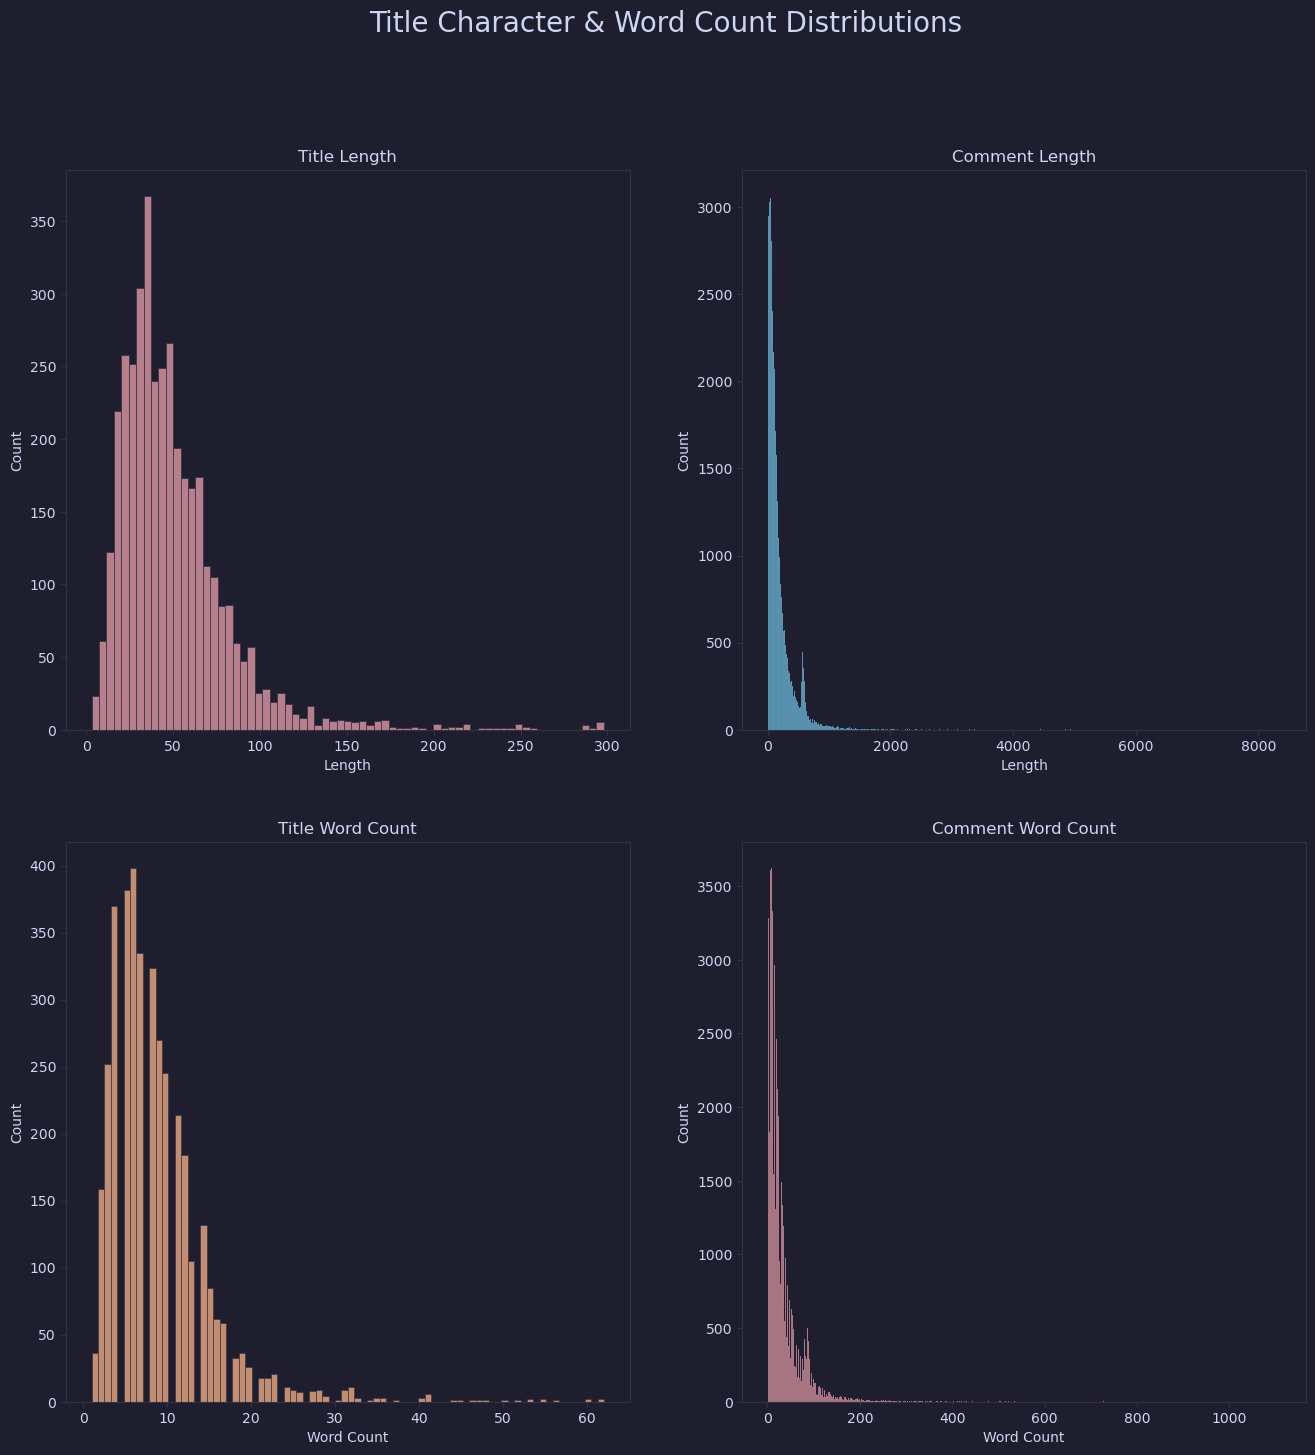

In [38]:
fig, ax =  plt.subplots(2, 2, figsize=(16,16))
sns.histplot(titles['title_length'], ax=ax[0,0],
             color=load_color("mocha", random.choice(cat_color)))
sns.histplot(comments['comment_length'], ax=ax[0,1],
             color=load_color("mocha", random.choice(cat_color)))
sns.histplot(titles['title_word_count'], ax=ax[1,0],
             color=load_color("mocha", random.choice(cat_color)))
sns.histplot(comments['comment_word_count'], ax=ax[1,1],
             color=load_color("mocha", random.choice(cat_color)))

ax[0,0].set(xlabel='Length', title='Title Length')
ax[0,1].set(xlabel='Length', title='Comment Length')
ax[1,0].set(xlabel='Word Count', title='Title Word Count')
ax[1,1].set(xlabel='Word Count', title='Comment Word Count')

fig.suptitle('Title Character & Word Count Distributions', fontsize=20);

These visuals don't help us much, because the upper ends are drastically bigger than the rest of each respective data set. Let's first look at how the distributions look, filtered by each subreddit.

In [39]:
### Making Filtered Dataframes

sd_titles = titles[titles['subreddit']=='SteamDeck'] 
sd_comments = comments[comments['subreddit']=='SteamDeck']
lg_titles = titles[titles['subreddit']=='linux_gaming']
lg_comments = comments[comments['subreddit']=='linux_gaming']

### Title Plots

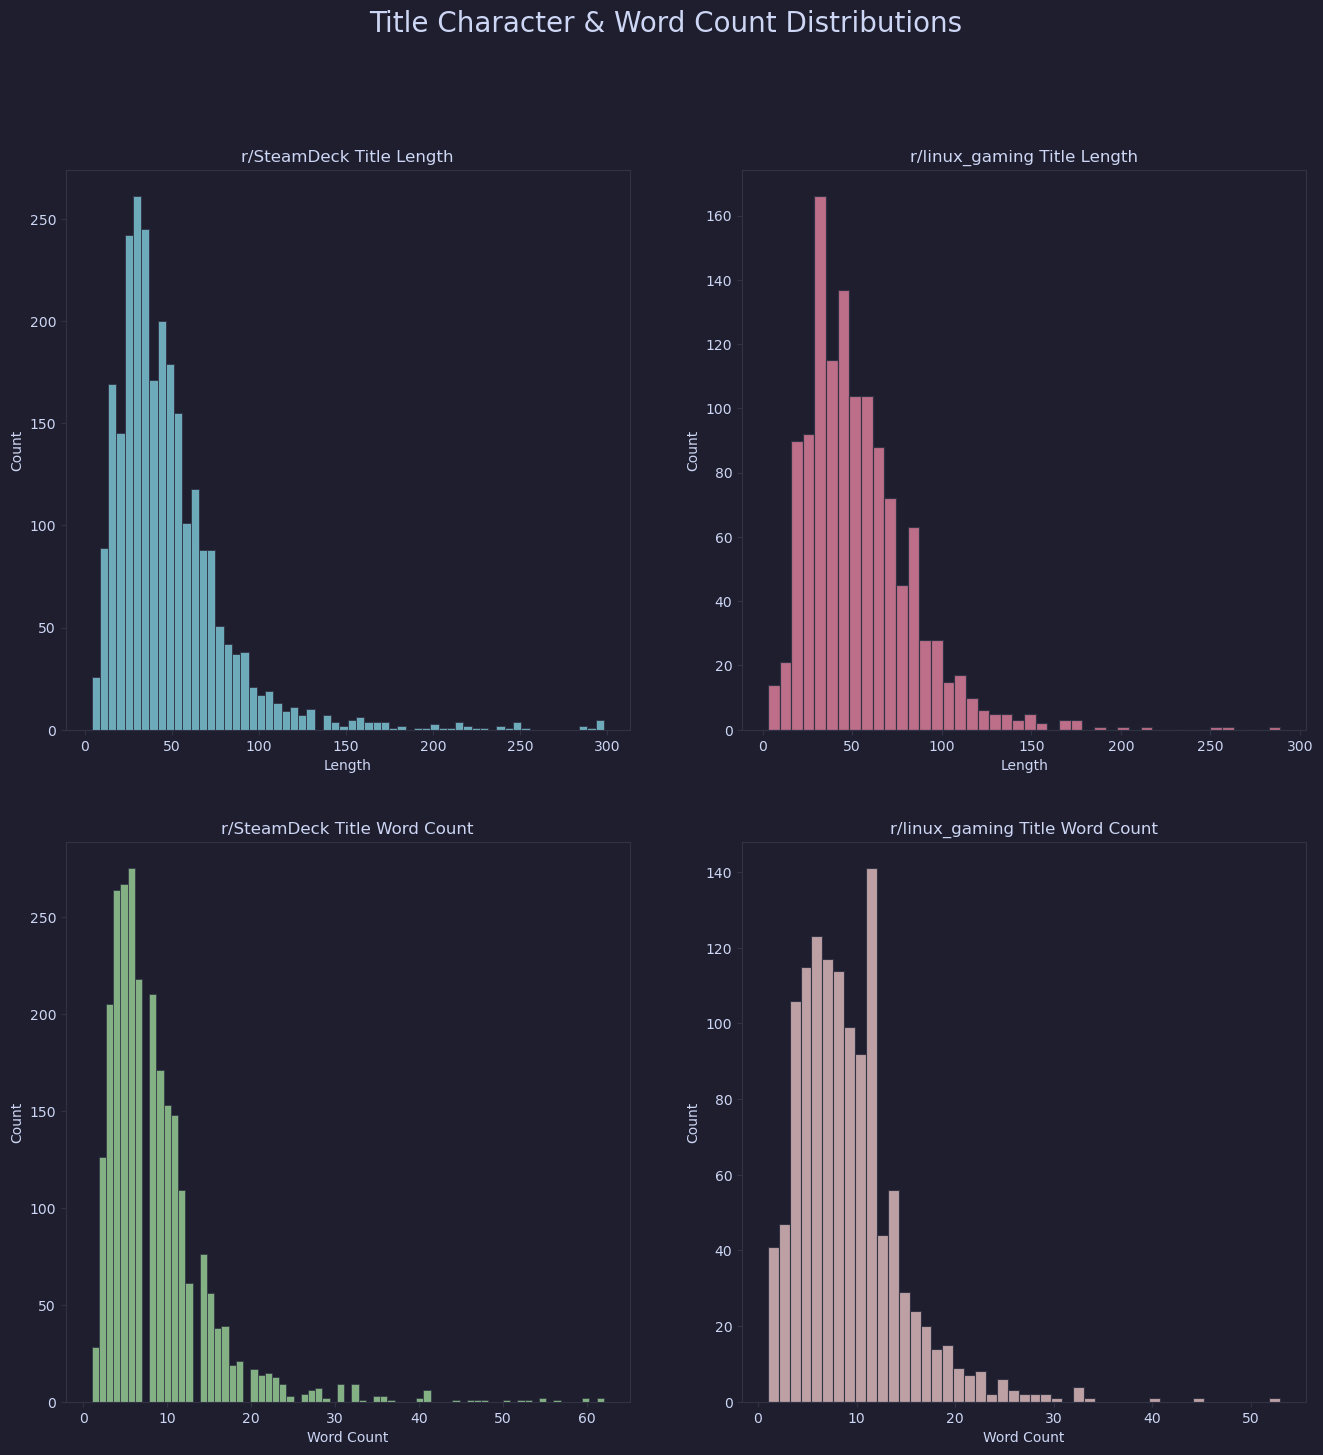

In [40]:
fig, ax =  plt.subplots(2, 2, figsize=(16,16))

# r/SteamDeck Title's Lengths
sns.histplot(sd_titles['title_length'], ax=ax[0,0],
             color=load_color("mocha", random.choice(cat_color)))

# r/linux_gaming Title's Lengths
sns.histplot(lg_titles['title_length'], ax=ax[0,1],
             color=load_color("mocha", random.choice(cat_color)))

# r/SteamDeck Title's Word Counts
sns.histplot(sd_titles['title_word_count'], ax=ax[1,0],
             color=load_color("mocha", random.choice(cat_color)))

# r/linux_gaming Title's Word Counts
sns.histplot(lg_titles['title_word_count'], ax=ax[1,1],
             color=load_color("mocha", random.choice(cat_color)))

ax[0,0].set(xlabel='Length', title='r/SteamDeck Title Length')
ax[0,1].set(xlabel='Length', title='r/linux_gaming Title Length')
ax[1,0].set(xlabel='Word Count', title='r/SteamDeck Title Word Count')
ax[1,1].set(xlabel='Word Count', title='r/linux_gaming Title Word Count')

fig.suptitle('Title Character & Word Count Distributions', fontsize=20);

It seems that r/SteamDeck title's willing to be a bit longer than titles on r/linux_gaming

### Comment Plots

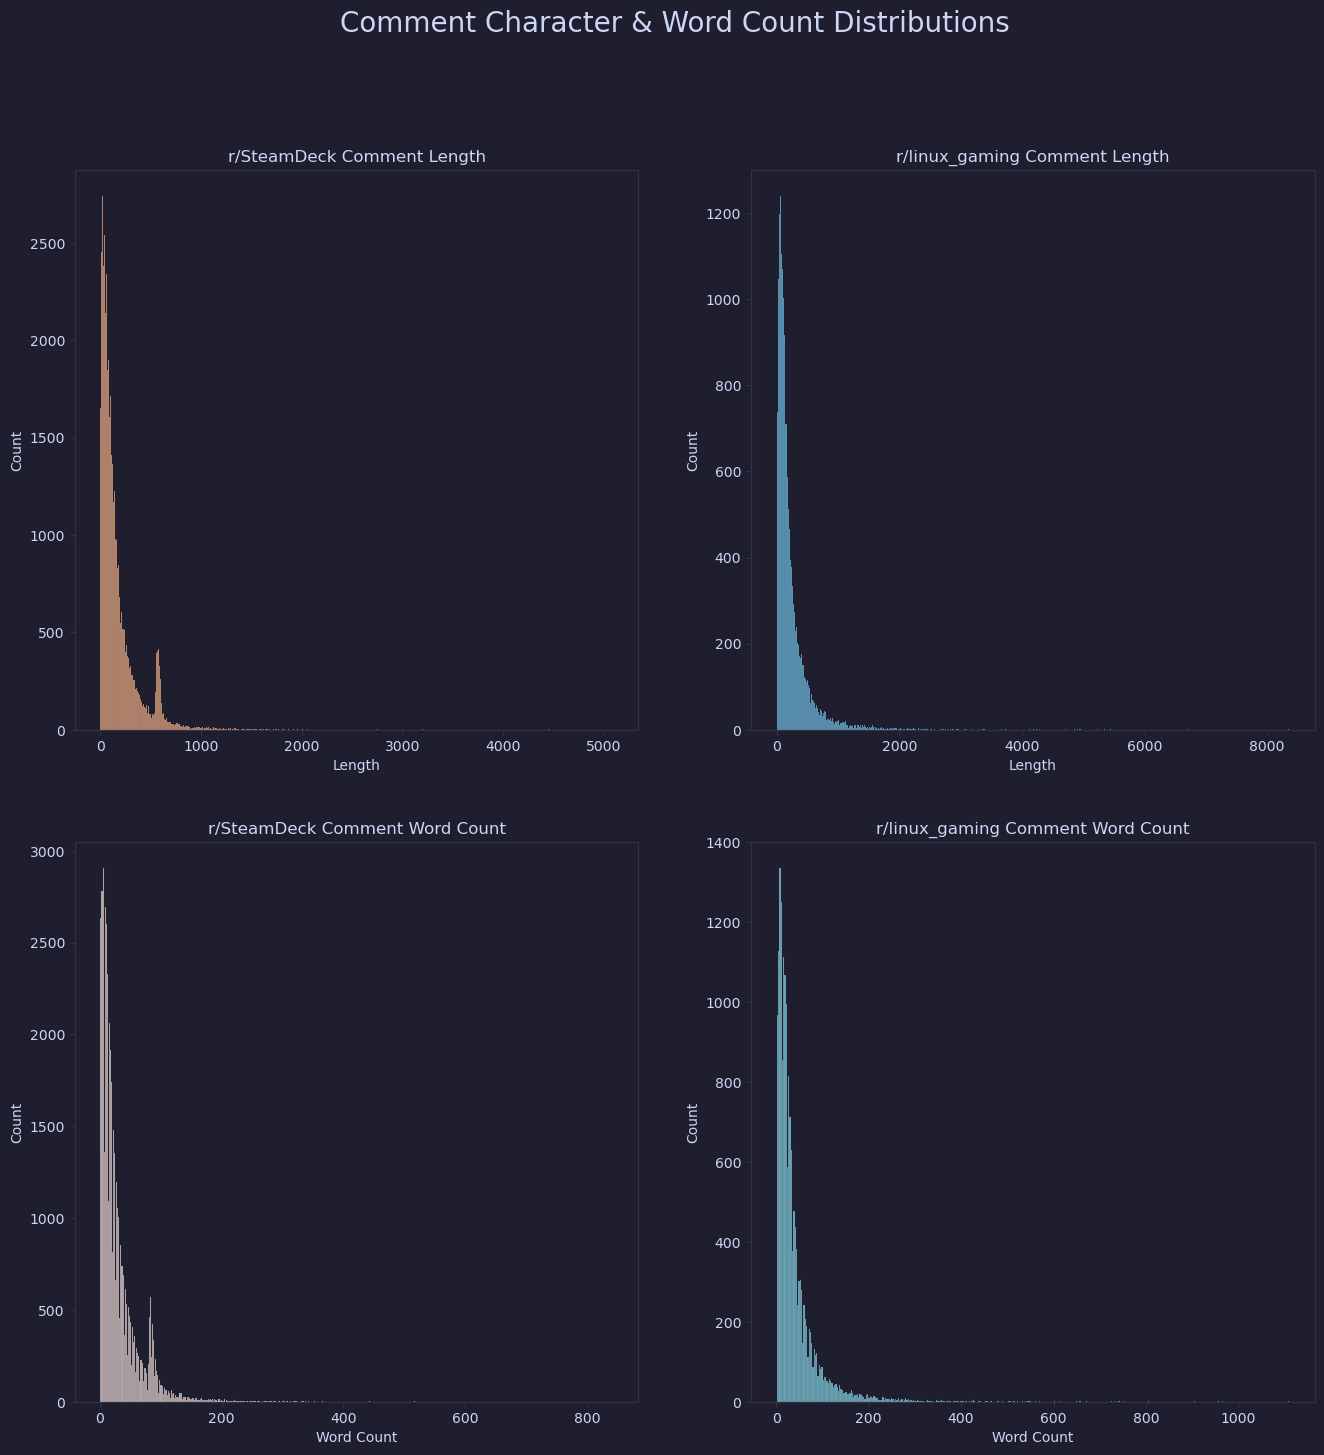

In [41]:
fig, ax =  plt.subplots(2, 2, figsize=(16,16))

# /SteamDeck Comment's Lengths
sns.histplot(sd_comments['comment_length'], ax=ax[0,0],
             color=load_color("mocha", random.choice(cat_color)))

# /linux_gaming Comment's Lengths
sns.histplot(lg_comments['comment_length'], ax=ax[0,1],
             color=load_color("mocha", random.choice(cat_color)))

# /SteamDeck Comment's Word Counts
sns.histplot(sd_comments['comment_word_count'], ax=ax[1,0],
             color=load_color("mocha", random.choice(cat_color)))

# /linux_gaming Comment's Word Counts
sns.histplot(lg_comments['comment_word_count'], ax=ax[1,1],
             color=load_color("mocha", random.choice(cat_color)))

ax[0,0].set(xlabel='Length', title='r/SteamDeck Comment Length')
ax[0,1].set(xlabel='Length', title='r/linux_gaming Comment Length')
ax[1,0].set(xlabel='Word Count', title='r/SteamDeck Comment Word Count')
ax[1,1].set(xlabel='Word Count', title='r/linux_gaming Comment Word Count')

fig.suptitle('Comment Character & Word Count Distributions', fontsize=20);

Even though r/linux_gaming has less data overall, we are seeeing more representation from it in the longer comments. 

## Recap

### RegEx
When we begin to proccess the data for modeling we should make sure to use RegEx to help us deal with various writing patterns, including:
- Using `/` to alternate different words that can fit in same place of a sentance.
- Using `-` to combine words together
- URLs of various popular websites
- Emojis
- etc

We do this by getting rid of everything other than alphanumeric characters.

### Differences in length
Although the two subreddits have fairly similar distributions, there are some noteworthy differences. r/SteamDeck seems to favor shorter length in titles and r/linux_gaming seems to favor longer comments. 

## Word EDA

We will now vectorize the words in the dataset and do some EDA on the words themselves that appear.

### Top 10 Most Common Words in Titles

In [59]:
cv = CountVectorizer(stop_words='english')

sd_titles_vect = cv.fit_transform(sd_titles['title'])
sd_titles_vect_df = pd.DataFrame(sd_titles_vect.todense(), columns=cv.get_feature_names_out())

lg_titles_vect = cv.fit_transform(lg_titles['title'])
lg_titles_vect_df = pd.DataFrame(lg_titles_vect.todense(), columns=cv.get_feature_names_out())

sd_comments_vect = cv.fit_transform(sd_comments['comments'])
sd_comments_vect_df = pd.DataFrame(sd_comments_vect.todense(), columns=cv.get_feature_names_out())

lg_comments_vect = cv.fit_transform(lg_comments['comments'])
lg_comments_vect_df = pd.DataFrame(lg_comments_vect.todense(), columns=cv.get_feature_names_out())

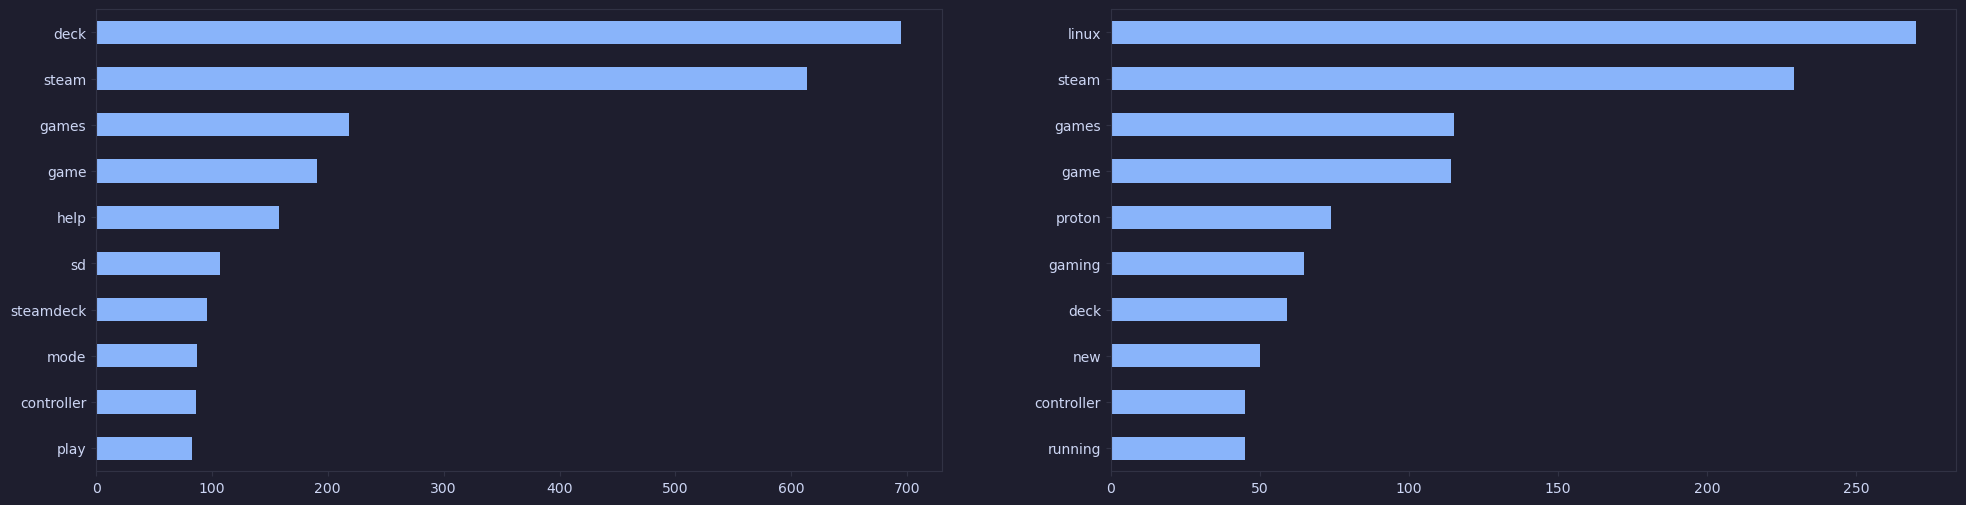

In [61]:
# Right Plot is r/SteamDeck and Left Plot is r/linux_gaming
fig, ax = plt.subplots(1, 2, figsize=(24,6))
sd_titles_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0])
lg_titles_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1])

ax[0].invert_yaxis()
ax[1].invert_yaxis();

### Top 10 Most Common Words in Comments

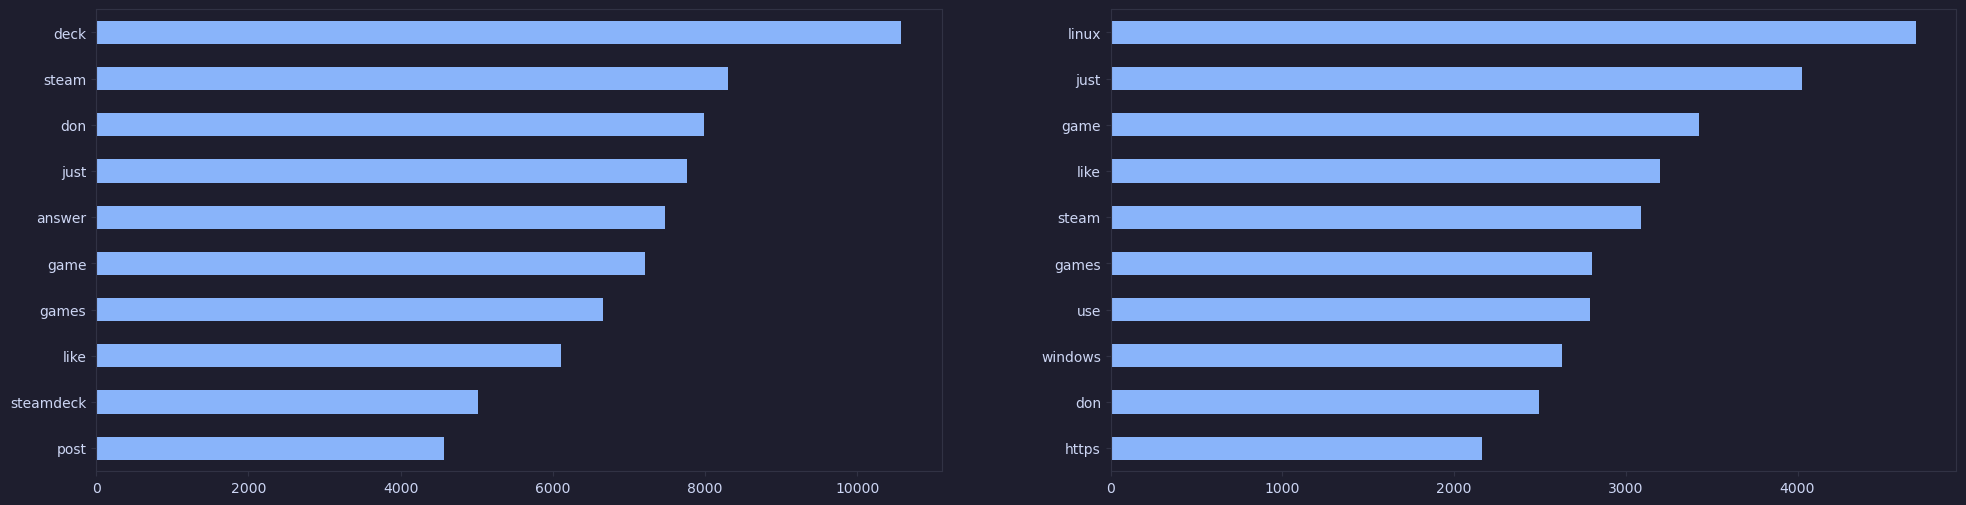

In [62]:
# Right Plot is r/SteamDeck and Left Plot is r/linux_gaming
fig, ax = plt.subplots(1, 2, figsize=(24,6))
sd_comments_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0])
lg_comments_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1])

ax[0].invert_yaxis()
ax[1].invert_yaxis();

## Bigrams

In [63]:
cv = CountVectorizer(stop_words='english', ngram_range=(2,2), max_features=1000)

sd_titles_vect = cv.fit_transform(sd_titles['title'])
sd_titles_vect_df = pd.DataFrame(sd_titles_vect.todense(), columns=cv.get_feature_names_out())

lg_titles_vect = cv.fit_transform(lg_titles['title'])
lg_titles_vect_df = pd.DataFrame(lg_titles_vect.todense(), columns=cv.get_feature_names_out())

sd_comments_vect = cv.fit_transform(sd_comments['comments'])
sd_comments_vect_df = pd.DataFrame(sd_comments_vect.todense(), columns=cv.get_feature_names_out())

lg_comments_vect = cv.fit_transform(lg_comments['comments'])
lg_comments_vect_df = pd.DataFrame(lg_comments_vect.todense(), columns=cv.get_feature_names_out())

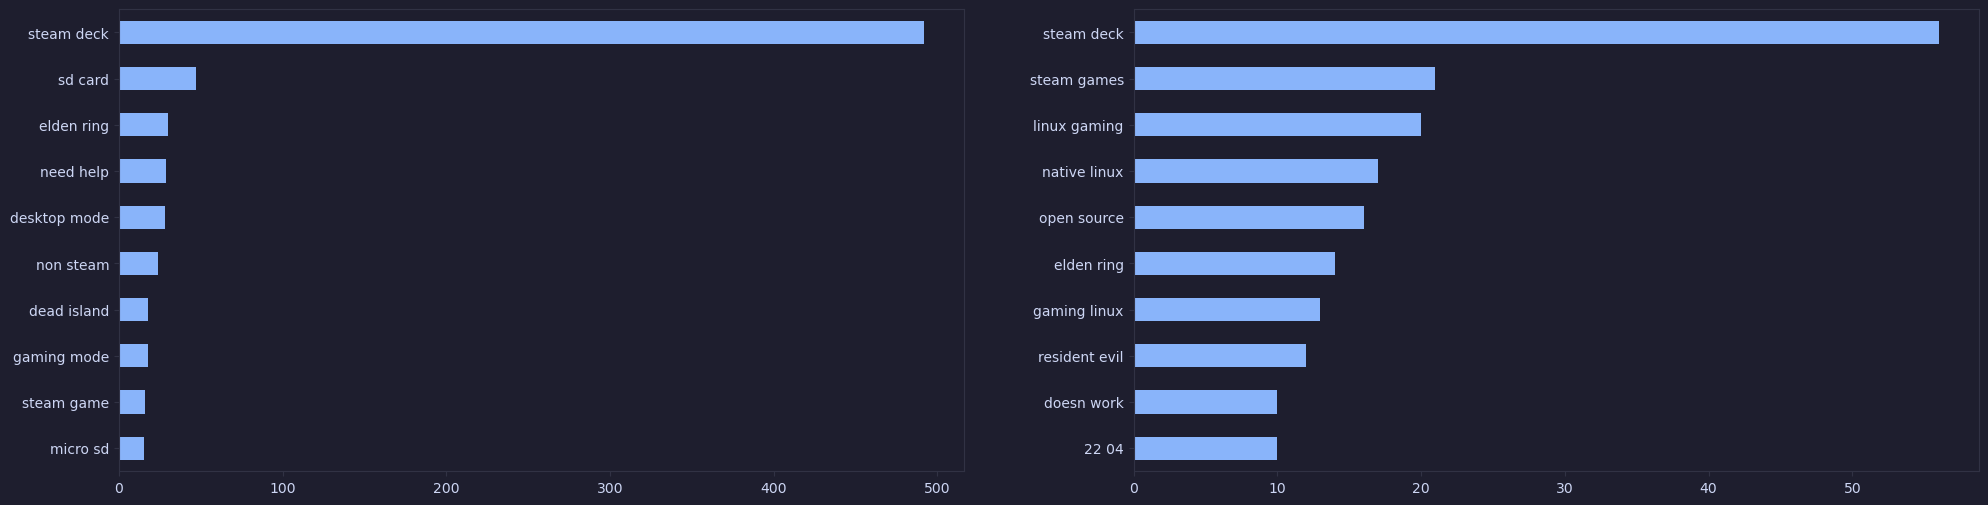

In [64]:
# Right Plot is r/SteamDeck and Left Plot is r/linux_gaming
fig, ax = plt.subplots(1, 2, figsize=(24,6))
sd_titles_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0])
lg_titles_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1])

ax[0].invert_yaxis()
ax[1].invert_yaxis();

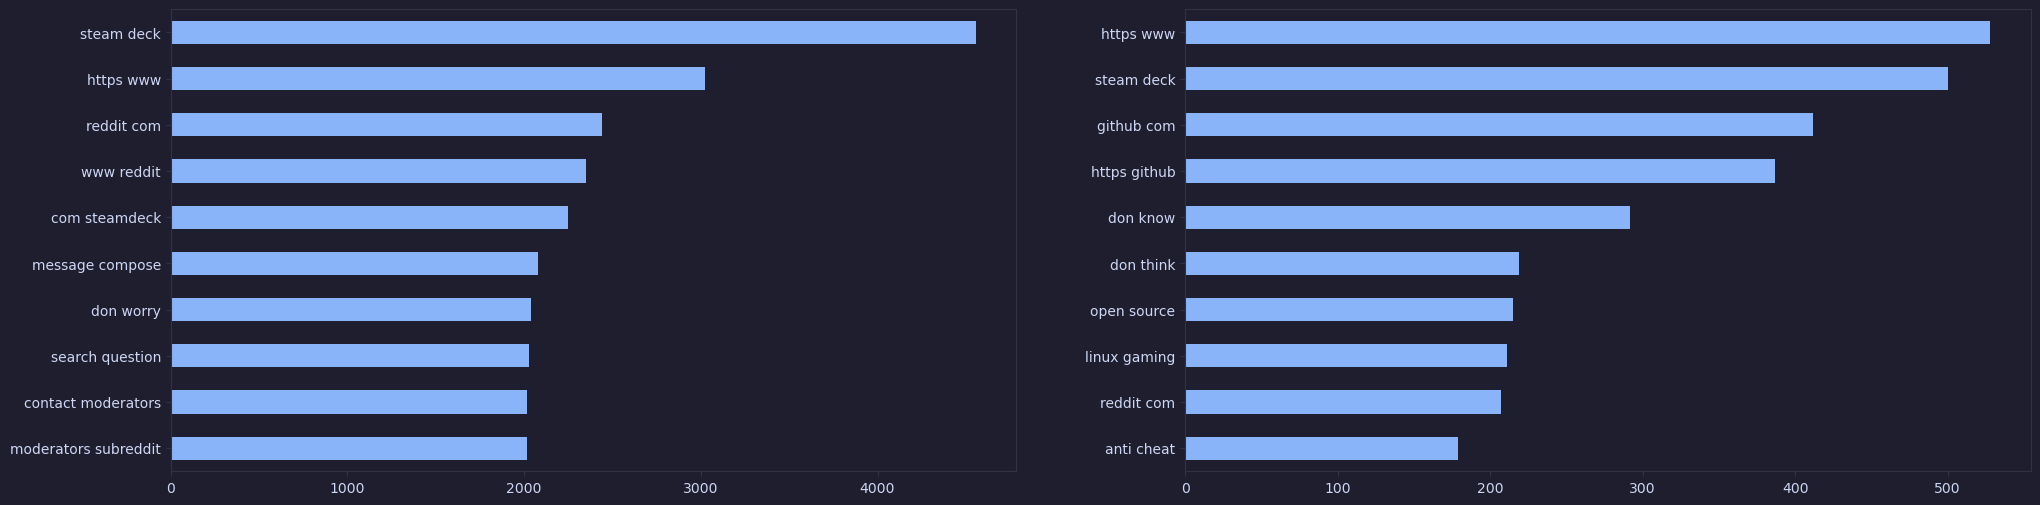

In [65]:
# Right Plot is r/SteamDeck and Left Plot is r/linux_gaming
fig, ax = plt.subplots(1, 2, figsize=(24,6))
sd_comments_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0])
lg_comments_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1])

ax[0].invert_yaxis()
ax[1].invert_yaxis();

### Trigrams

In [66]:
cv = CountVectorizer(stop_words='english', ngram_range=(3,3), max_features=1000)

sd_titles_vect = cv.fit_transform(sd_titles['title'])
sd_titles_vect_df = pd.DataFrame(sd_titles_vect.todense(), columns=cv.get_feature_names_out())

lg_titles_vect = cv.fit_transform(lg_titles['title'])
lg_titles_vect_df = pd.DataFrame(lg_titles_vect.todense(), columns=cv.get_feature_names_out())

sd_comments_vect = cv.fit_transform(sd_comments['comments'])
sd_comments_vect_df = pd.DataFrame(sd_comments_vect.todense(), columns=cv.get_feature_names_out())

lg_comments_vect = cv.fit_transform(lg_comments['comments'])
lg_comments_vect_df = pd.DataFrame(lg_comments_vect.todense(), columns=cv.get_feature_names_out())

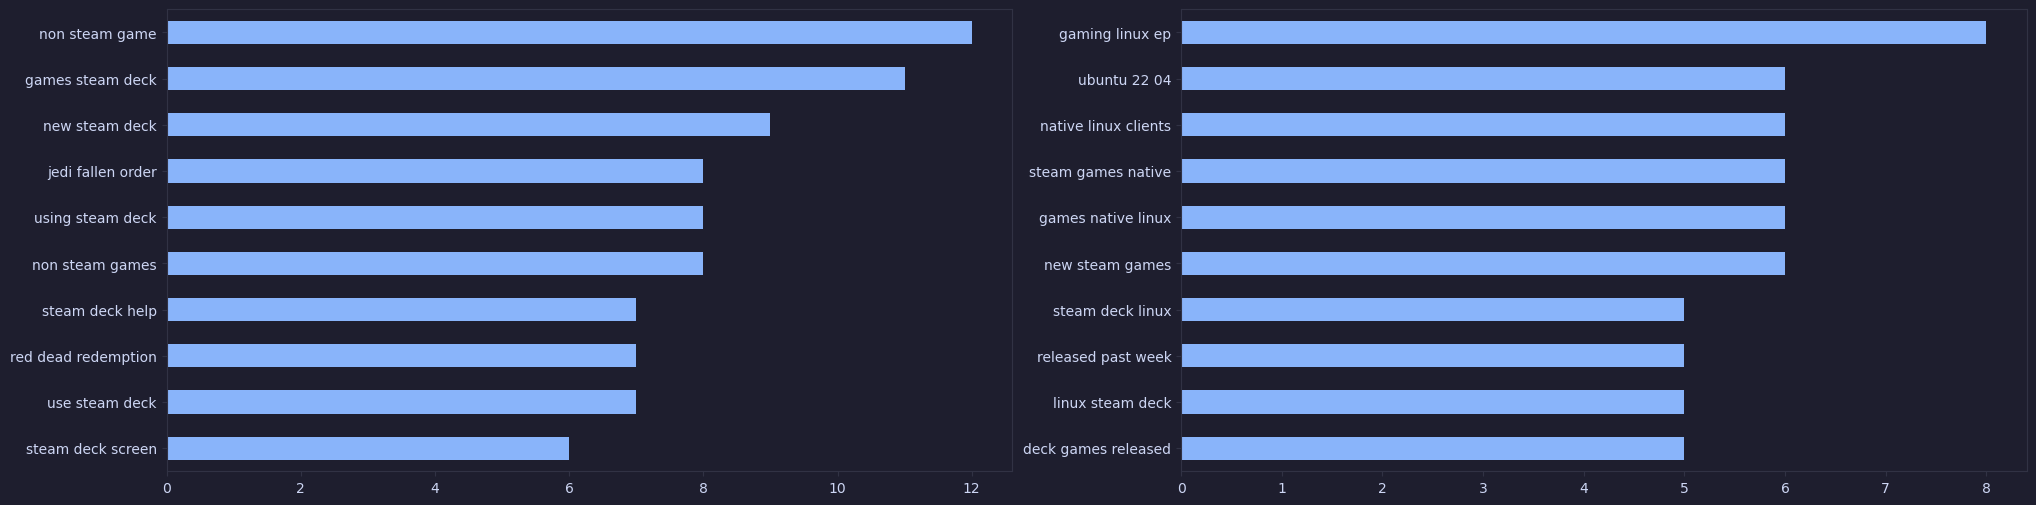

In [67]:
# Right Plot is r/SteamDeck and Left Plot is r/linux_gaming
fig, ax = plt.subplots(1, 2, figsize=(24,6))
sd_titles_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0])
lg_titles_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1])

ax[0].invert_yaxis()
ax[1].invert_yaxis();

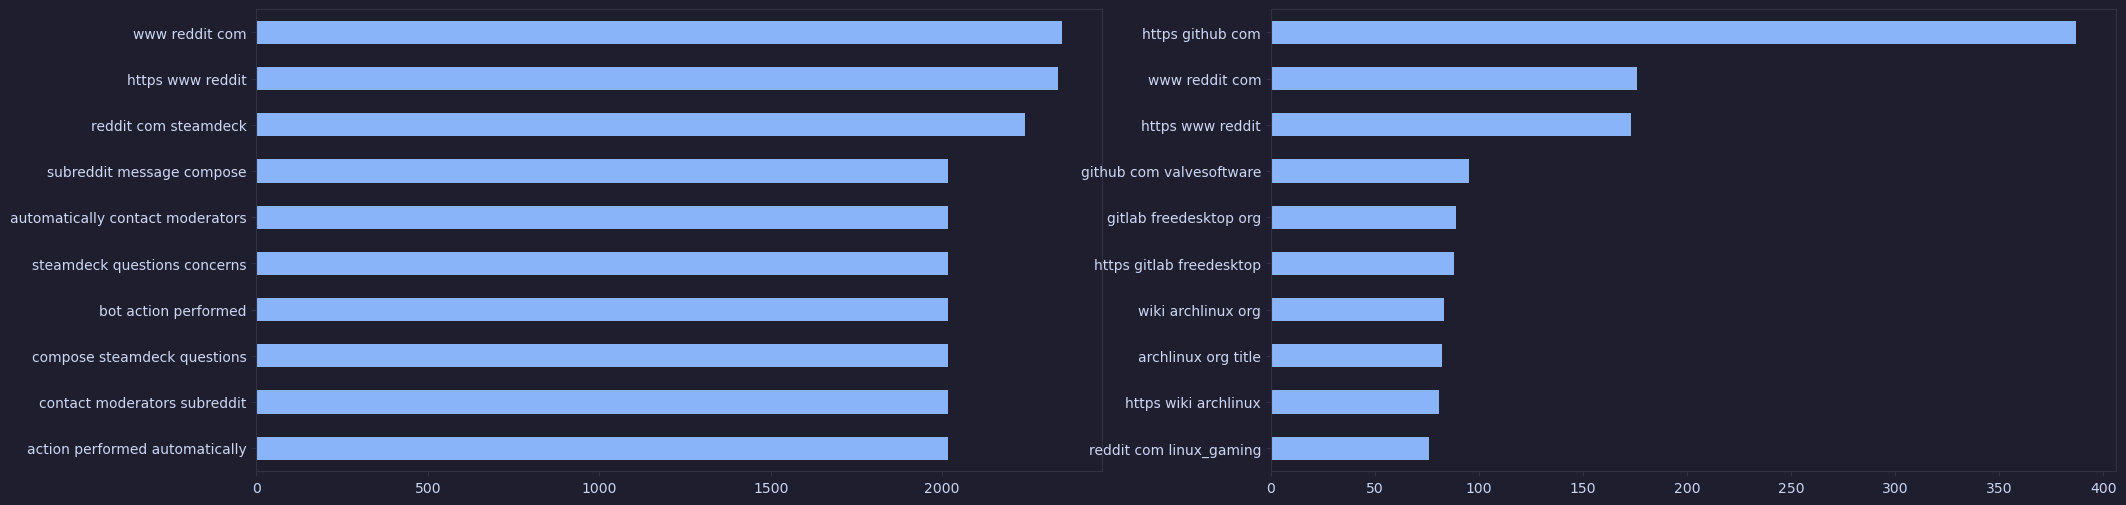

In [68]:
# Right Plot is r/SteamDeck and Left Plot is r/linux_gaming
fig, ax = plt.subplots(1, 2, figsize=(24,6))
sd_comments_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0])
lg_comments_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1])

ax[0].invert_yaxis()
ax[1].invert_yaxis();

Based on these lists we can begin to start to gain some insights on the poular topics on these subreddits. r/SteamDeck seems to a lot more community focused and will talk a lot about moderation, questions, or link to other reddit pages (most likely other posts withn there own subreddit. r/linux_gaming seems to be more techincally focused. The links shared a lot in the comments tend to be to public git repos or pages on the arch wiki. There also seems to be talk about more specific parts of game software, like anti-cheat, and talk about operating systems.

## Sentiment Analysis

Finally let's do some basic sentament analysis on the subreddits. By doing this we can get a slight idea on a potential idea of positivity vs negativity on the subreddits. Reddit has a bit of a reputation for negativity at times, so it would be interesting to see what some sentiment analysis will show us.

In [70]:
sent = SentimentIntensityAnalyzer()

In [77]:
sent.polarity_scores(sd_comments['comments'][20])

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Let's write some functions that will store the different sentiment analysis scores.

In [90]:
def get_title_sent_score(df):
    sent_scores_neg = []
    sent_scores_neu = []
    sent_scores_pos = []
    sent_scores_compound = []
    
    for index in df.index:
        sent_scores_neg.append(sent.polarity_scores(df['title'][index])['neg'])
        sent_scores_neu.append(sent.polarity_scores(df['title'][index])['neu'])
        sent_scores_pos.append(sent.polarity_scores(df['title'][index])['pos'])
        sent_scores_compound.append(sent.polarity_scores(df['title'][index])['compound'])
    
    df['negative_sentiment'] = sent_scores_neg
    df['neutral_sentiment'] = sent_scores_neu
    df['positive_sentiment'] = sent_scores_pos
    df['compund_sentiment'] = sent_scores_compound
    
    return

In [91]:
def get_comment_sent_score(df):
    sent_scores_neg = []
    sent_scores_neu = []
    sent_scores_pos = []
    sent_scores_compound = []
    
    for index in df.index:
        sent_scores_neg.append(sent.polarity_scores(df['comments'][index])['neg'])
        sent_scores_neu.append(sent.polarity_scores(df['comments'][index])['neu'])
        sent_scores_pos.append(sent.polarity_scores(df['comments'][index])['pos'])
        sent_scores_compound.append(sent.polarity_scores(df['comments'][index])['compound'])
    
    df['negative_sentiment'] = sent_scores_neg
    df['neutral_sentiment'] = sent_scores_neu
    df['positive_sentiment'] = sent_scores_pos
    df['compund_sentiment'] = sent_scores_compound
    
    return

In [92]:
get_title_sent_score(titles)

get_comment_sent_score(comments)

In [93]:
titles.head()

,title_id,title,subreddit,title_length,title_word_count,negative_sentiment,neutral_sentiment,positive_sentiment,compund_sentiment
0,12ysmfy,improved wine gaming with execute,linux_gaming,33,5,0.000,0.563,0.437,0.4767
1,12yb3qz,there is a lot of native linux games what would you recomend,linux_gaming,62,12,0.000,1.000,0.000,0.0000
2,12yfibp,what is your favorite open source linux game mine is wideland best way to describe is the way settlers 3 should have been,linux_gaming,124,23,0.000,0.735,0.265,0.8020
3,12yagh3,wiki is getting attacked by spam bots,linux_gaming,38,7,0.524,0.476,0.000,-0.6705
4,12yg5qp,psa the 8bitdo ultimate bluetooth 2 4gz controller doesn't work out of the box on most linux distributions,linux_gaming,111,18,0.000,1.000,0.000,0.0000


In [94]:
comments.head()

,comment_id,comments,subreddit,comment_length,comment_word_count,negative_sentiment,neutral_sentiment,positive_sentiment,compund_sentiment
0,jhjsr22,i m sorry you lost all your friends from gaming too much,SteamDeck,56,11,0.263,0.511,0.226,0.1280
1,jhjz43t,this feels like an all too poignant commentary on my life a bunch of games no friends and no money,SteamDeck,102,20,0.176,0.600,0.224,0.2960
2,jhjtkl6,i also have 0 00 money,SteamDeck,23,5,0.000,1.000,0.000,0.0000
3,jhjrdnr,i was worried your friend count had gone up it was only that your games quadrupled whew,SteamDeck,90,17,0.113,0.722,0.165,0.2500
4,jhk1d07,haha i honestly thought the 100 referred to cash in the wallet and the joke being about losing 100 friends just realised it was about the 100 games,SteamDeck,156,29,0.072,0.613,0.315,0.8271


In [96]:
### Remaking Filtered Dataframes

sd_titles = titles[titles['subreddit']=='SteamDeck'] 
sd_comments = comments[comments['subreddit']=='SteamDeck']
lg_titles = titles[titles['subreddit']=='linux_gaming']
lg_comments = comments[comments['subreddit']=='linux_gaming']

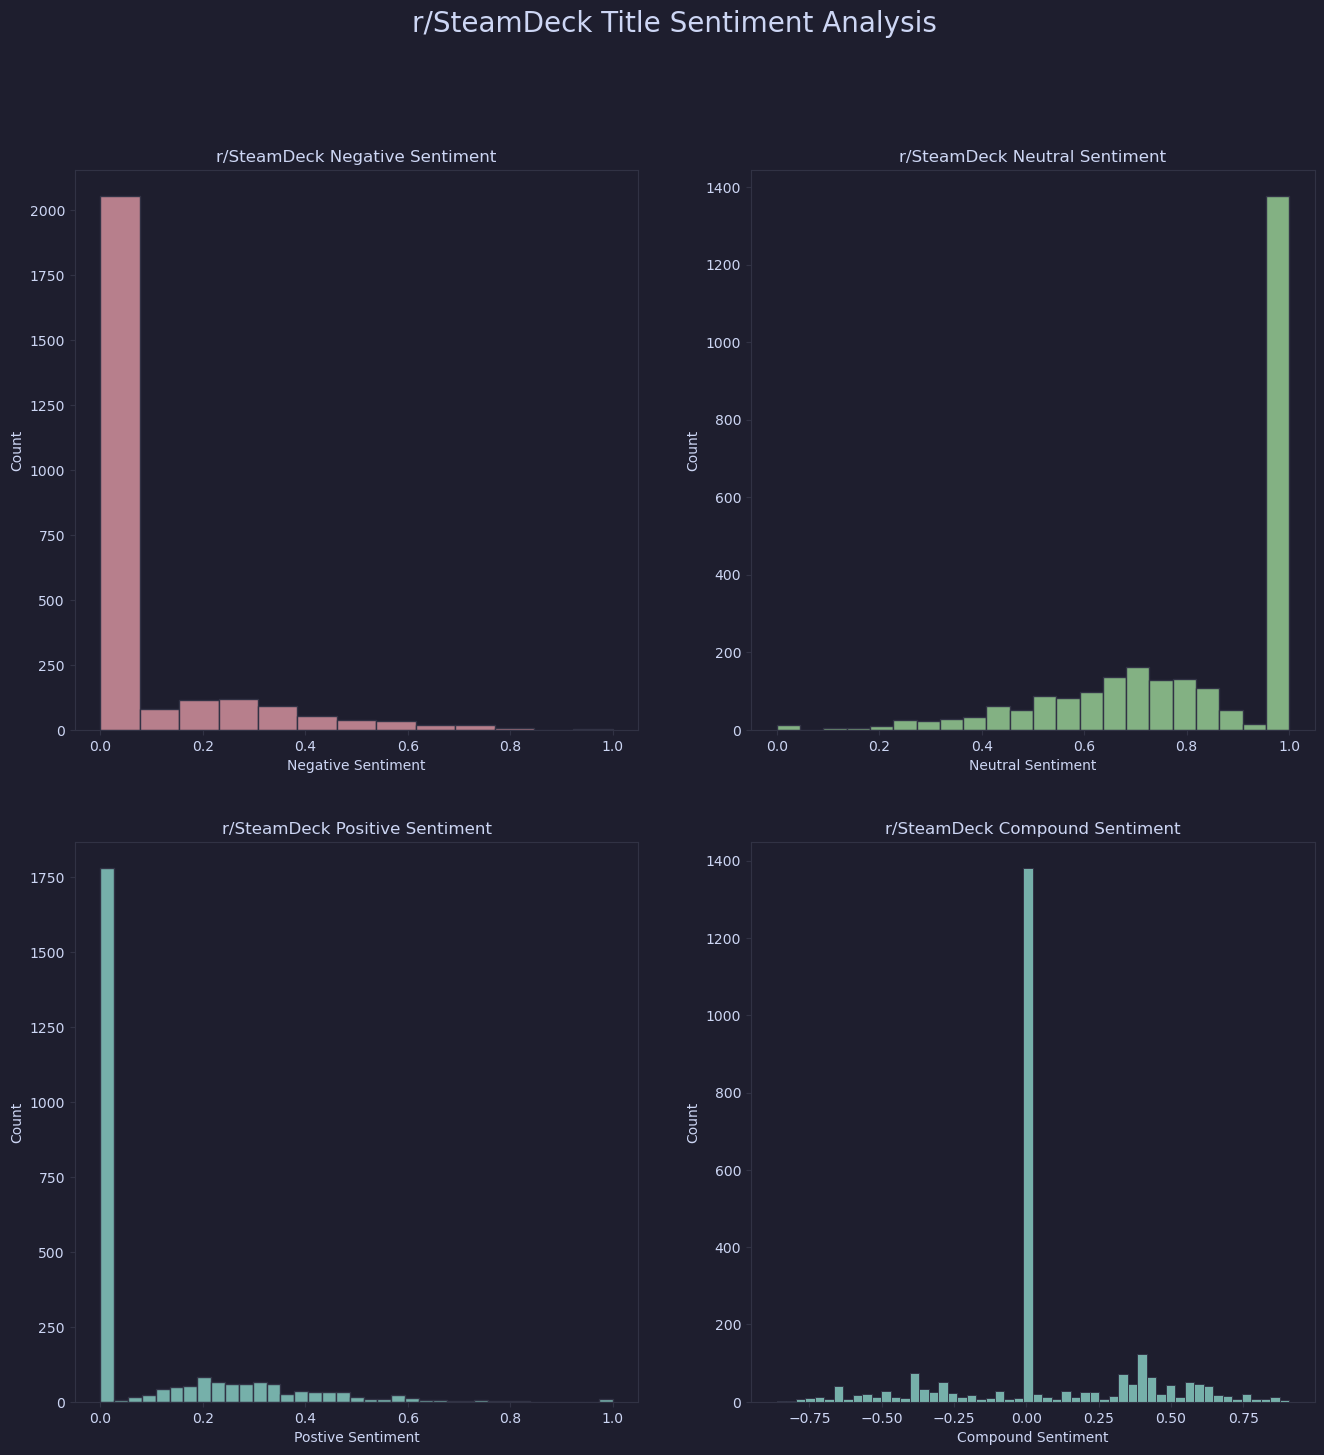

In [97]:
fig, ax =  plt.subplots(2, 2, figsize=(16,16))

sns.histplot(sd_titles['negative_sentiment'], ax=ax[0,0],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(sd_titles['neutral_sentiment'], ax=ax[0,1],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(sd_titles['positive_sentiment'], ax=ax[1,0],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(sd_titles['compund_sentiment'], ax=ax[1,1],
             color=load_color("mocha", random.choice(cat_color)))

ax[0,0].set(xlabel='Negative Sentiment', title='r/SteamDeck Negative Sentiment')
ax[0,1].set(xlabel='Neutral Sentiment', title='r/SteamDeck Neutral Sentiment')
ax[1,0].set(xlabel='Postive Sentiment', title='r/SteamDeck Positive Sentiment')
ax[1,1].set(xlabel='Compound Sentiment', title='r/SteamDeck Compound Sentiment')

fig.suptitle('r/SteamDeck Title Sentiment Analysis', fontsize=20);

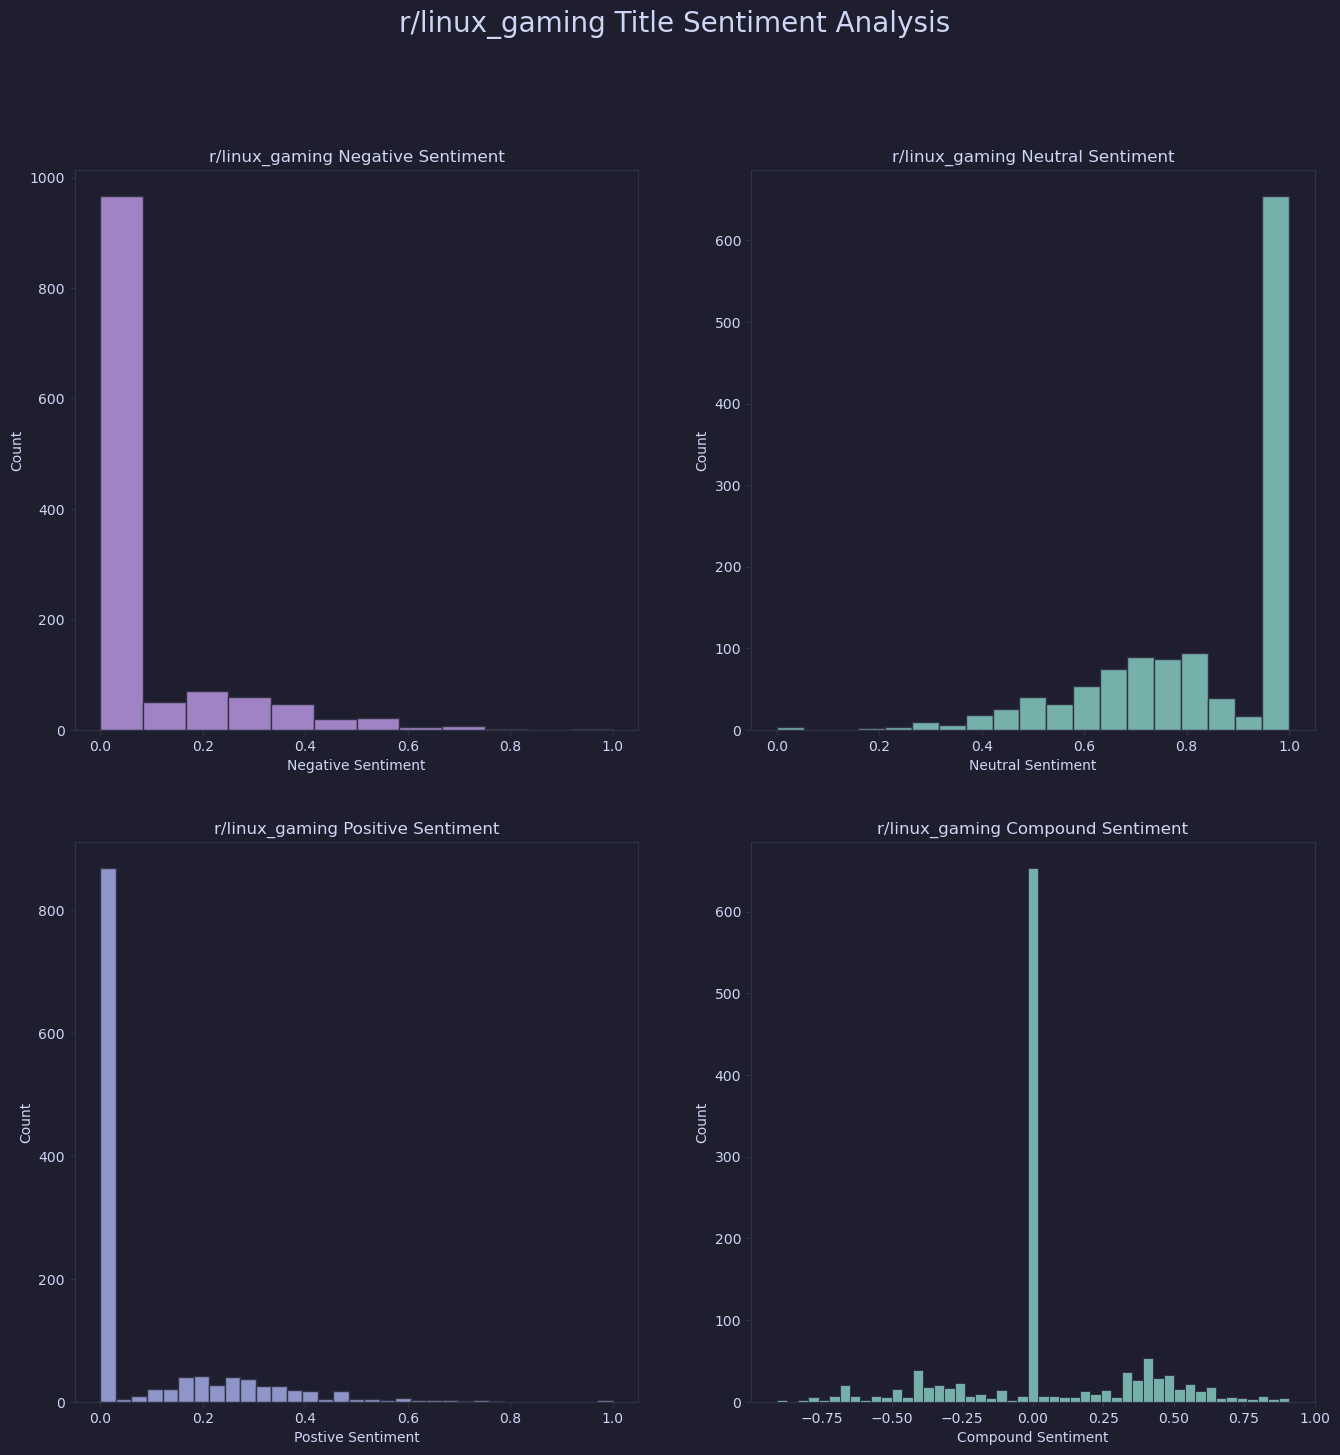

In [98]:
fig, ax =  plt.subplots(2, 2, figsize=(16,16))

sns.histplot(lg_titles['negative_sentiment'], ax=ax[0,0],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(lg_titles['neutral_sentiment'], ax=ax[0,1],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(lg_titles['positive_sentiment'], ax=ax[1,0],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(lg_titles['compund_sentiment'], ax=ax[1,1],
             color=load_color("mocha", random.choice(cat_color)))

ax[0,0].set(xlabel='Negative Sentiment', title='r/linux_gaming Negative Sentiment')
ax[0,1].set(xlabel='Neutral Sentiment', title='r/linux_gaming Neutral Sentiment')
ax[1,0].set(xlabel='Postive Sentiment', title='r/linux_gaming Positive Sentiment')
ax[1,1].set(xlabel='Compound Sentiment', title='r/linux_gaming Compound Sentiment')

fig.suptitle('r/linux_gaming Title Sentiment Analysis', fontsize=20);

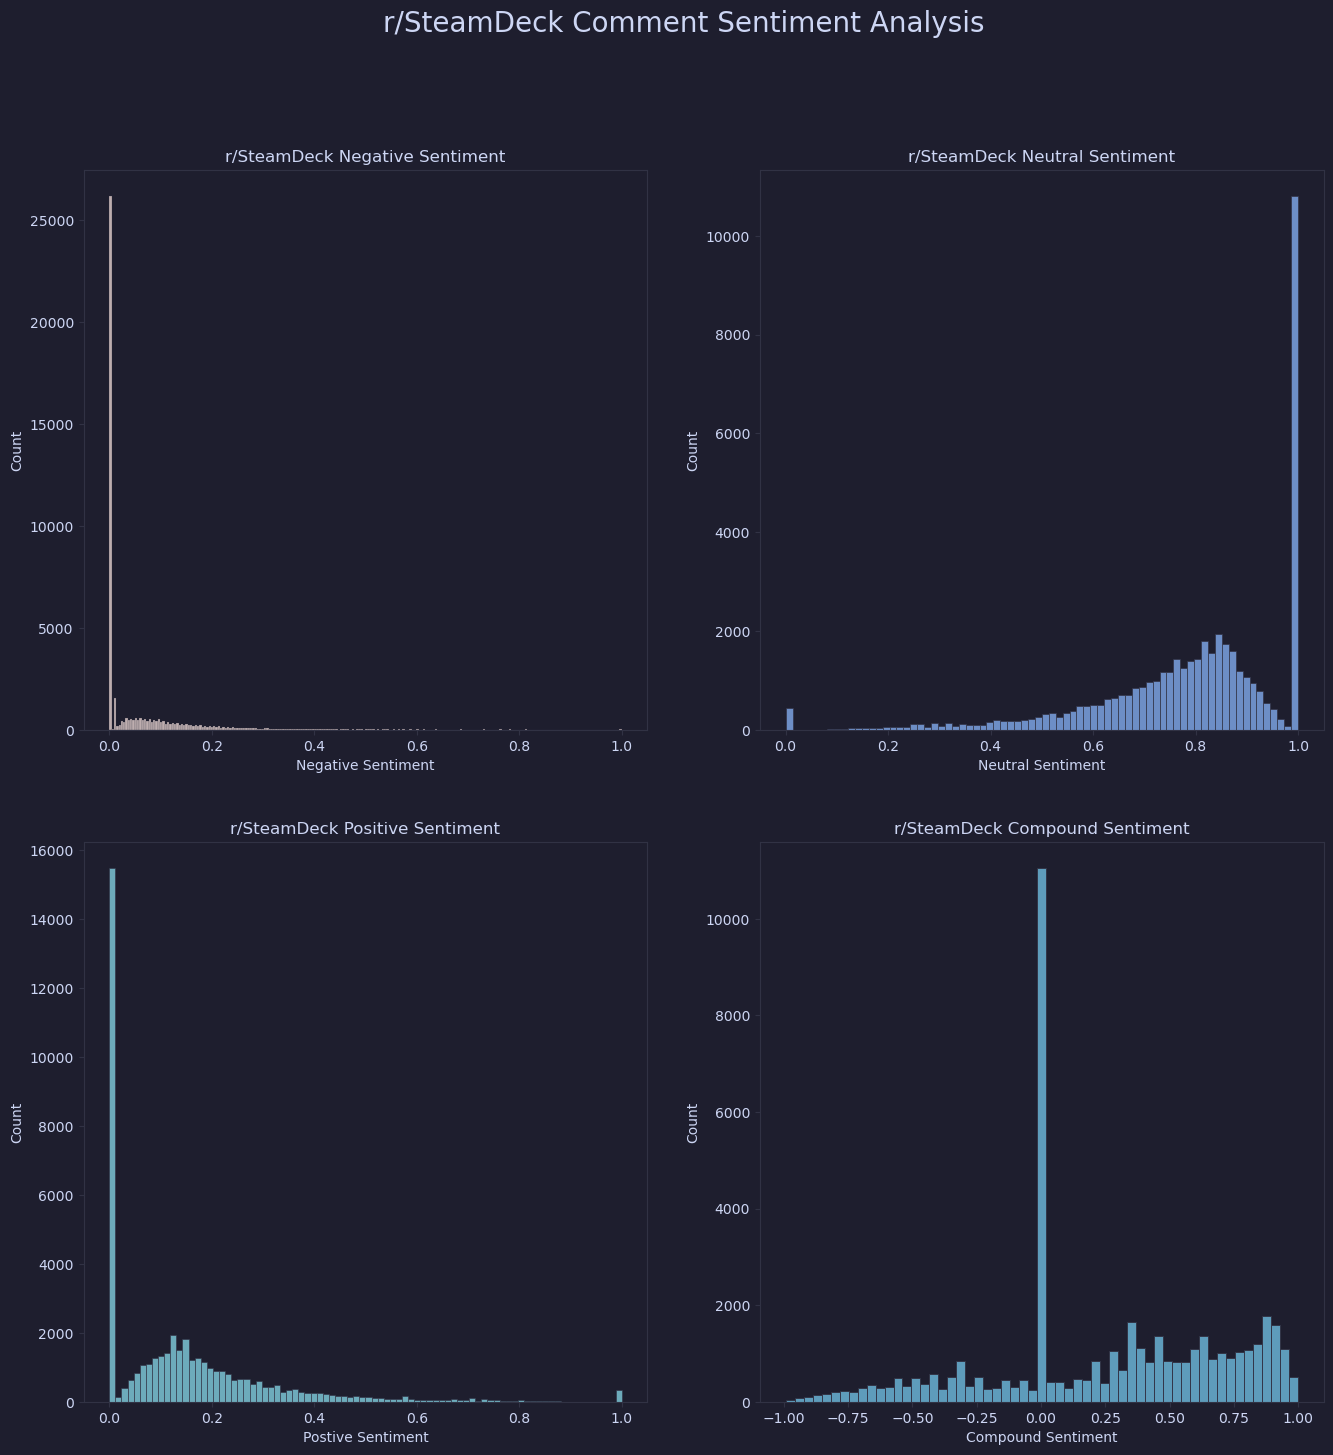

In [101]:
fig, ax =  plt.subplots(2, 2, figsize=(16,16))

sns.histplot(sd_comments['negative_sentiment'], ax=ax[0,0],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(sd_comments['neutral_sentiment'], ax=ax[0,1],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(sd_comments['positive_sentiment'], ax=ax[1,0],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(sd_comments['compund_sentiment'], ax=ax[1,1],
             color=load_color("mocha", random.choice(cat_color)))

ax[0,0].set(xlabel='Negative Sentiment', title='r/SteamDeck Negative Sentiment')
ax[0,1].set(xlabel='Neutral Sentiment', title='r/SteamDeck Neutral Sentiment')
ax[1,0].set(xlabel='Postive Sentiment', title='r/SteamDeck Positive Sentiment')
ax[1,1].set(xlabel='Compound Sentiment', title='r/SteamDeck Compound Sentiment')

fig.suptitle('r/SteamDeck Comment Sentiment Analysis', fontsize=20);

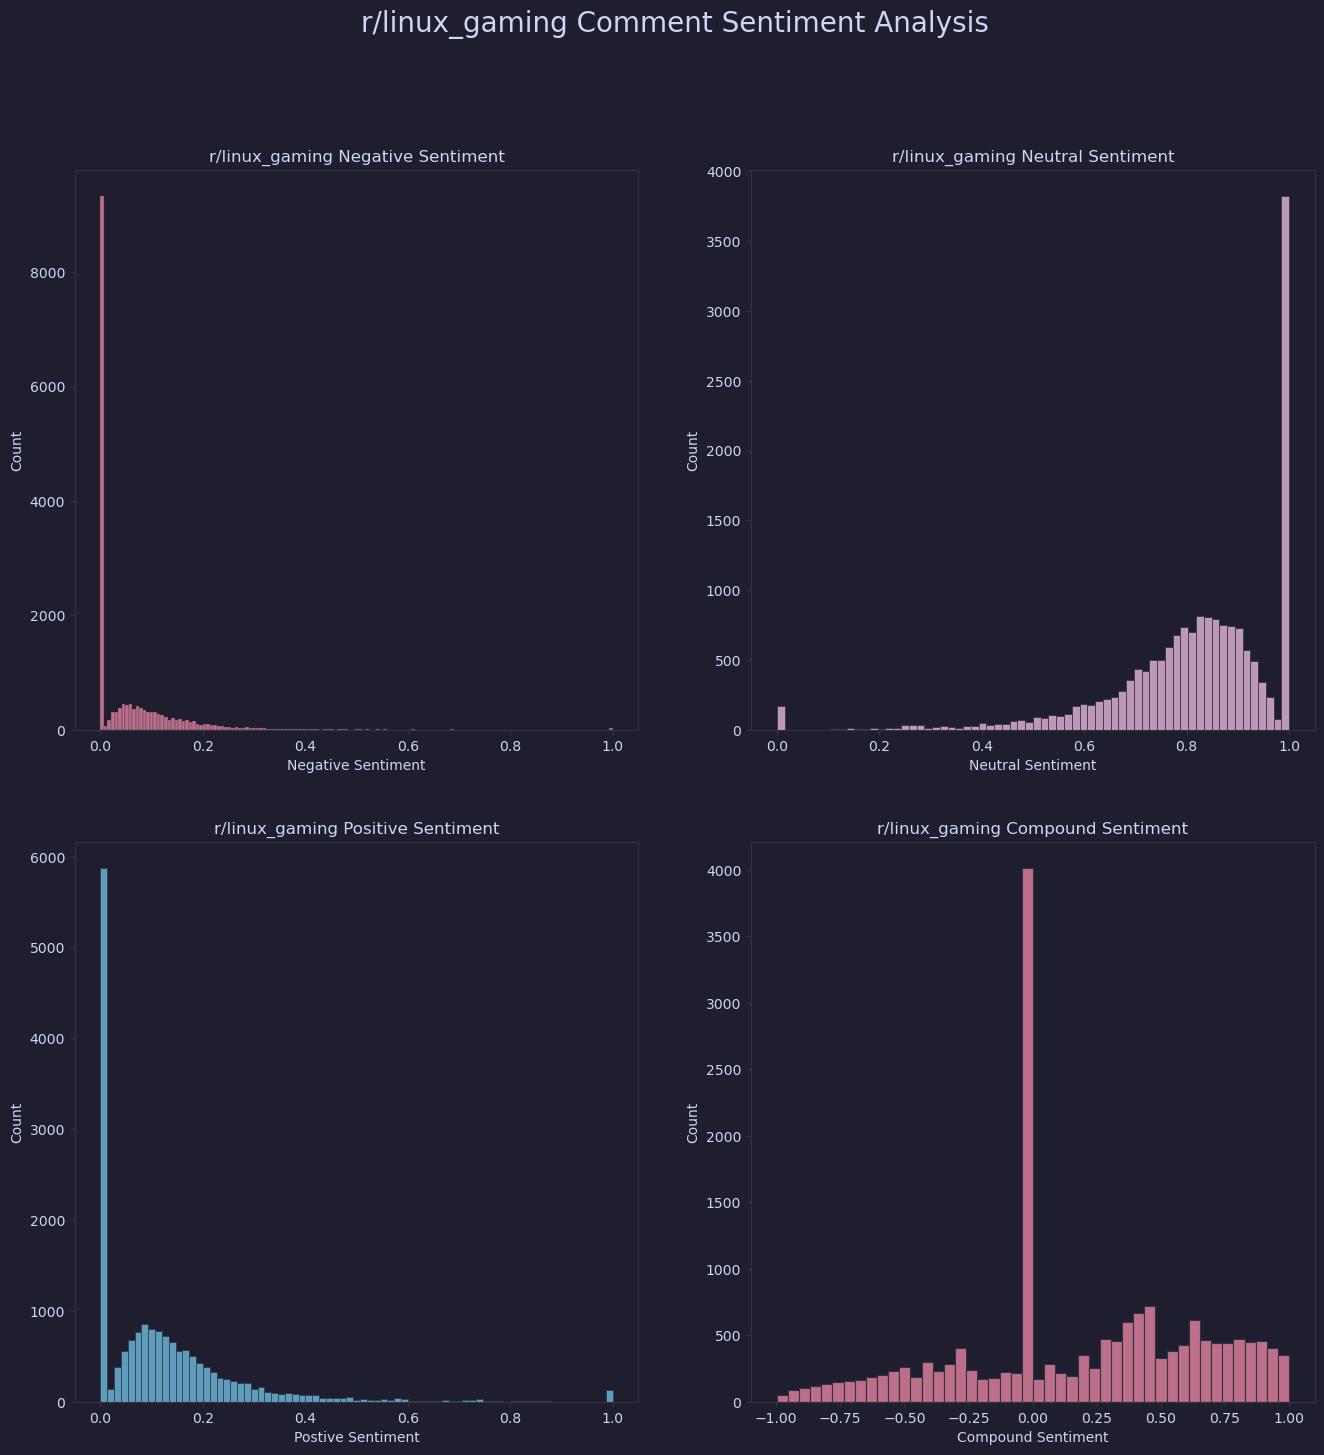

In [102]:
fig, ax =  plt.subplots(2, 2, figsize=(16,16))

sns.histplot(lg_comments['negative_sentiment'], ax=ax[0,0],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(lg_comments['neutral_sentiment'], ax=ax[0,1],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(lg_comments['positive_sentiment'], ax=ax[1,0],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(lg_comments['compund_sentiment'], ax=ax[1,1],
             color=load_color("mocha", random.choice(cat_color)))

ax[0,0].set(xlabel='Negative Sentiment', title='r/linux_gaming Negative Sentiment')
ax[0,1].set(xlabel='Neutral Sentiment', title='r/linux_gaming Neutral Sentiment')
ax[1,0].set(xlabel='Postive Sentiment', title='r/linux_gaming Positive Sentiment')
ax[1,1].set(xlabel='Compound Sentiment', title='r/linux_gaming Compound Sentiment')

fig.suptitle('r/linux_gaming Comment Sentiment Analysis', fontsize=20);

Based on the histograms, it looks like when it comes to Title's of posts, there is very little detectable sentiment. However, when We look at comment, things get a bit more interesting. In general, it seem both sub reddits support more positive sentiment, than negative, however, that statement is much more true for r/SteamDeck than it is for r/linux_gaming. r/linux_gaming seems to have more noticeable amount of negative sentiment than r/SteamDeck.